In [52]:
## %matplotlib inline
import pylab as pl
from astropy import units as u, constants, visualization
visualization.quantity_support()
pl.style.use('dark_background')
pl.rcParams['figure.dpi'] = 150

# Model Fitting & Measurement in practice

AST 4723

This lecture covers:

1. A review of spectral line formation
2. Line measurement procedures: by eye, moment analysis, fitting
3. Continuum / baseline modeling
4. Spectroscopic flatfielding
5. Line measurements with normalized spectra (Equivalent Width)

# Measurements

We can make several measurements from the spectra we've obtained:

1. The wavelength/frequency/velocity of the line
2. The intensity of the line
3. The width

These tell us about the physical properties of the object we're looking at.

# Line Profiles

So what is a "spectral line" anyway?

The HI spin-flip transition is a quantum process that produces a photon at a specific frequency, and it *always* produces a photon at that frequency - in the rest frame of the particle. 

The Balmer H-alpha lines are produced in a slightly different but still quantized process producing a photon at a fixed wavelength in the rest frame of the particle.

# Line Profiles - Doppler Shift

The "line profile" we observe is caused by *doppler shift* in the line center.

The Doppler formula (in the "radio convention" approximation) is:

$$ \frac{\Delta v}{c} = \frac{\nu_{rest} - \nu_{observed}}{\nu_{rest}} $$

In the "optical convention" it is
$$ \frac{\Delta v}{c} = \frac{ \lambda_{observed} - \lambda_{rest}}{\lambda_{rest}} $$

EXERCISE:  Prove that these are _not_ equivalent definitions.

# Line Profiles - Doppler Shift

What causes $\nu_{observed}$ to vary, then?

Often the most important process is *thermal broadening*.

Particles in a gas move according to the Maxwell-Boltzmann Distribution

# Maxwell-Boltzmann distribution

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Simulation_of_gas_for_relaxation_demonstration.gif/450px-Simulation_of_gas_for_relaxation_demonstration.gif" style="max-height: 600px">


# Line Profiles - Maxwell-Boltzmann Distribution

The Maxwell-Boltzmann velocity vector distribution tells you how fast a particle is moving along your line-of-sight.  

$$c_s = \sqrt{\frac{k_B T}{m}}$$

$k_B$ is Boltzmann's constant, $T$ is the gas temperature, and $m$ is the particle mass.  $c_s$ is the *speed of sound*, and is the width of the Boltzmann velocity distribution for an isothermal (single-temperature) gas. 

This gives a probability distribution:

$$p(v_{los}) = \exp\left[\frac{-v_{los}^2}{2 c_s^2}\right] = \exp\left[\frac{-m v_{los}^2}{2 k_B T}\right]$$


# Line Profiles - Maxwell-Boltzmann Distribution

This is a Gaussian distribution, $f(x) \propto e^{-x^2}$:

$$p(v_{los}) = \exp\left[\frac{-v_{los}^2}{2 c_s^2}\right]$$

It tells you how many particles are moving at each velocity.  For example...

In [53]:
# Example: There are 1000 Hydrogen particles with T=100 K
temperature = 100*u.K
hydrogen_mass = 1*u.Da # a "Dalton" is equal to one Atomic Mass Unit
soundspeed = ((constants.k_B * temperature / hydrogen_mass)**0.5).to(u.km/u.s)
# sample particle velocities from a "normal" (Gaussian) distribution
particle_velocities = np.random.randn(1000) * soundspeed

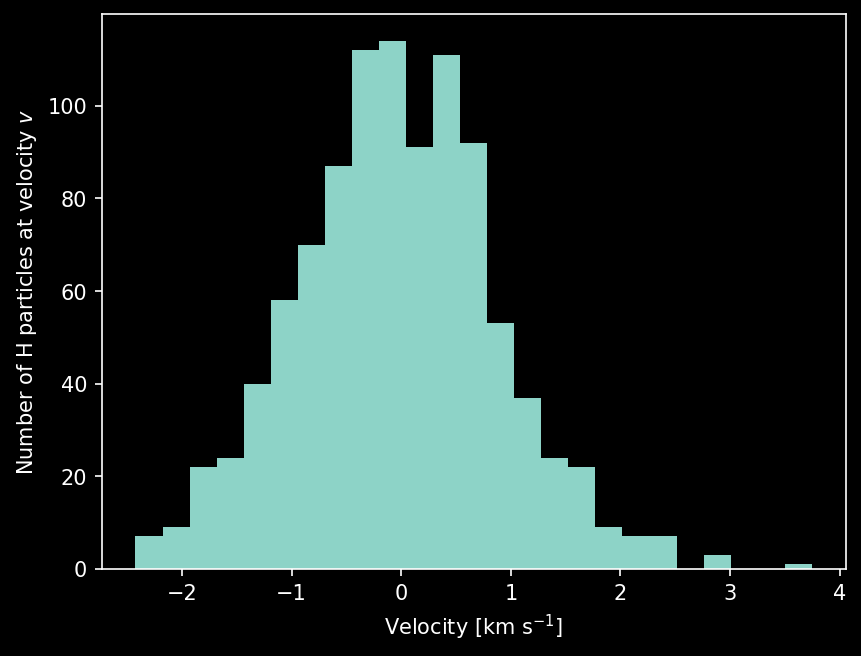

In [54]:
pl.ylabel("Number of H particles at velocity $v$")
pl.xlabel("Velocity [km s$^{-1}$]")
_=pl.hist(particle_velocities, bins=25);

# Line Profiles - Doppler Shift

A moving particle produces a photon at a different frequency as determined by the doppler formula:

$$ \frac{\Delta v}{c} = \frac{\lambda_{moving} - \lambda_{rest}}{\lambda_{rest}}$$

gives

$$ \lambda_{moving} = \lambda_{rest} \left( 1 + \frac{\Delta v}{c}\right)$$

Radio version:

$$ \frac{\Delta v}{c} = \frac{\nu_{rest} - \nu_{moving}}{\nu_{rest}} $$

gives

$$ \nu_{moving} = \nu_{rest} \left(1 - \frac{\Delta v}{c}\right) $$

# Line Profiles - Doppler Shift
The doppler formula combined with the Boltzmann distribution gives:
$$ \frac{\Delta v}{c} = \frac{\lambda_{moving} - \lambda_{rest}}{\lambda_{rest}} =  \frac{\lambda_{los} - \lambda_{rest}}{\lambda_{rest}} $$

$$p(v_{los}) = \exp\left[\frac{-v_{los}^2}{2 c_s^2}\right]$$



$$ p(\nu_{los}) =  \exp\left[\frac{-\left[c(\lambda_{los}-\lambda_{rest})/\lambda_{rest}\right]^2}{2 c_s^2}\right] $$


# Line Profiles - Doppler Shift - radio version
The doppler formula combined with the Boltzmann distribution gives:
$$ \frac{\Delta v}{c} = \frac{\nu_{rest} - \nu_{moving}}{\nu_{rest}} =  \frac{\nu_{rest} - \nu_{los}}{\nu_{rest}} $$

$$p(v_{los}) = \exp\left[\frac{-v_{los}^2}{2 c_s^2}\right]$$



$$ p(\nu_{los}) =  \exp\left[\frac{-\left[c(\nu_{rest}-\nu_{los})/\nu_{rest}\right]^2}{2 c_s^2}\right] $$


# Line Profiles - Doppler Shift

This is the line profile produced by an isothermal gas:

$$ p(\nu_{los}) =  \exp\left[\frac{-\left[c(\lambda_{los}-\lambda_{rest})/\lambda_{rest}\right]^2}{2 c_s^2}\right] $$


# Line Profile - Measurement

Most line profiles are dominated by motion and end up with Gaussian profiles.  There are other physical effects, including *pressure broadening* and *natural width* (from the Heisenberg uncertainty principle) that we'll discuss later, but for now we assume all line emission is broadened by motion.

We start with an example _emission_ profile, but the same principles generally hold for _absorption_ lines as well.

Given that starting assumption, we can measure physical properties of the gas from the line profile.

In [55]:
# a simulated line profile
nu_hi = 1420.405751 * u.MHz
bandwidth = 2.5 * u.MHz
frequency_axis = np.linspace(nu_hi - bandwidth/2, nu_hi + bandwidth/2, 2048)
# assume we're measuring something in Janskys
model_line_profile = np.exp(-(constants.c * (nu_hi - frequency_axis)/(nu_hi * soundspeed ))**2 / 2) * u.Jy

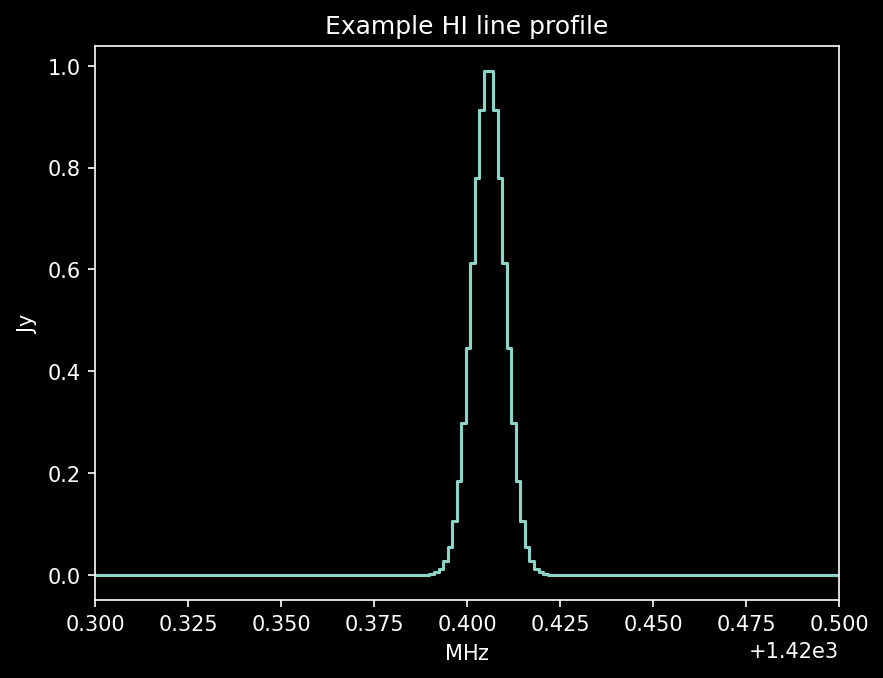

In [56]:
pl.plot(frequency_axis, model_line_profile, drawstyle='steps-mid')
pl.xlim(1420.3,1420.5);
pl.title("Example HI line profile");

# Line Profile - Measurement

The *width* tells us about the *velocity distribution*, which can be used to infer the temperature (in some cases).

How do we measure the width?  A few possibilities exist:
1. Eyeball it
2. Use *moment analysis*
3. Fit a model function to the data

# Line Profile - Measurement

The *width* tells us about the *velocity distribution*, which can be used to infer the temperature (in some cases).

How do we measure the width?  A few possibilities exist:
1. Eyeball it - inaccurate, but robust=failure-proof (you'll never get wildly wrong answers)
2. Use *moment analysis* - accurate, robust, best in most cases
3. Fit a model function to the data - accurate, flimsy, provides more information & works in more situations

# Line Profile - Measurement

The eyeball method: A Gaussian distribution has a well-defined width.  

The full-width at half-maximum (FWHM) is related to the width $\sigma$ as:

$$ FWHM = \sqrt{8 \ln 2}~\sigma$$

The width of a thermally broadened line is $\sigma = c_s$, so if we can estimate how wide the line is "by eye", we can get a quick estimate of the sound speed and therefore the temperature.

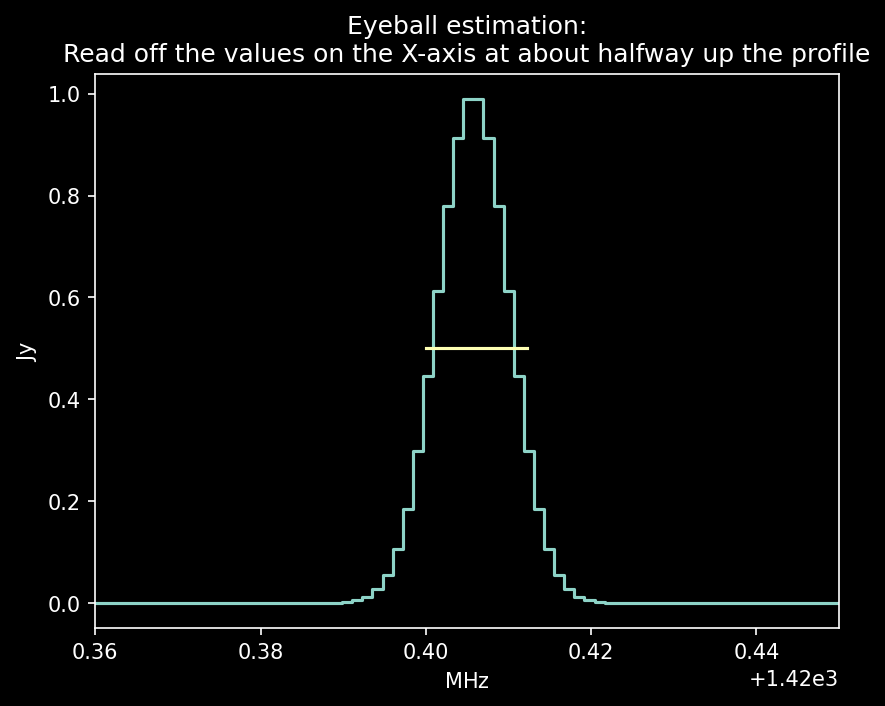

In [57]:
# drop a ruler onto the plot and measure the FWHM... you can get pretty close
pl.plot(frequency_axis, model_line_profile, drawstyle='steps-mid')
pl.xlim(1420.36,1420.45)
pl.title("Eyeball estimation:\nRead off the values on the X-axis at about halfway up the profile")
pl.plot([1420.4,1420.4122], [0.5,0.5]);

# Line Profile - Moment Analysis definitions

Moment Analysis is the quickest, simplest quantitative approach.  It is pretty _robust_ (i.e., it doesn't fail often) and is accurate.  It's generally the best method when it can be used.

The *zero'th moment* is the integral of the distribution:

$$m_0 = \int p(\nu) d\nu$$


The first moment is the *centroid*:

$$m_1 = \frac{\int \nu p(\nu) d\nu}{\int p(\nu) d\nu}$$

The second *central* moment measures the width:

$$m_2 = \frac{\int (\nu - \nu_{center})^2 p(\nu) d \nu}{\int p(\nu) d\nu} $$

n'th-order *central* moments are also used, but rarely.  We won't use them in this class, but you may hear of them occasionally.

$$m_n = \frac{\int (\nu - \nu_{center})^n p(\nu) d \nu}{\int p(\nu) d\nu} $$

_skew_ is $m_3$, _kurtosis_ is $m_4$ and can't be treated with antibiotics.

# Line Profile - Moment 0

What does moment 0 mean?
$$m_0 = \int p(\nu) d\nu$$

 This is the "total intensity" or "integrated intensity" and represents the total amount of light received from the line.  It will have units of "flux units" times "X-axis units"; for example, Jy Hz or K km/s.

In practice, we calculate this as 
$$ m_0 = \Sigma S_\nu \Delta \nu$$
$S_\nu$ is the recorded brightness value, and $\Delta \nu$ is the width of a channel. 

In [58]:
# example moment0 / integrated intensity measurement we might make for an HI line
delta_nu = frequency_axis[1] - frequency_axis[0]
moment0 = (model_line_profile * delta_nu).sum()
moment0

<Quantity 0.01082926 Jy MHz>

# Line Profile - Moment 1

What does moment 1 mean?

$$m_1 = \frac{\int \nu p(\nu) d\nu}{\int p(\nu) d\nu}$$


$m_1$ is the *weighted average* of the X-axis $\nu$.  It has the same units as $\nu$ - frequency.

In practice, we calculate this as 

$$m_1 = \frac{\Sigma \nu S_\nu \Delta \nu}{m_0}$$

where $\Delta \nu$ is the width of a spectral channel (spectral pixel).

$$m_1 = \frac{\Sigma \nu S_\nu \Delta \nu}{m_0}$$


In [59]:
# moment 1 calculation as written out
moment1 = (frequency_axis * model_line_profile * delta_nu).sum() / moment0
moment1

<Quantity 1420.405751 MHz>

In [60]:
# this is equivalent to taking the intensity-weighted average of the frequency
np.average(frequency_axis, weights=model_line_profile)

<Quantity 1420.405751 MHz>

# Line Profile - Moment 2

What does moment 2 mean?
$$m_2 = \frac{\int (\nu - \nu_{center})^2 p(\nu) d \nu}{\int p(\nu) d\nu} $$

$m_2$ is the *intensity-weighted variance*.  It has units $[\nu]^2$.  Recall that *variance* is the square of the *standard deviation*.  The *Gaussian width* $\sigma=m_2^{1/2}$.

We subtract out $m_1$ from each frequency because we're calculating the variance around a central point.

In practice, we calculate this as 
$$m_2 = \frac{\Sigma \left(\nu - m_1\right)^2 S_\nu \Delta \nu}{m_0}$$

$$m_2 = \frac{\Sigma \left(\nu - m_1\right)^2 S_\nu \Delta \nu}{m_0}$$

In [61]:
moment2 = ( (frequency_axis - moment1)**2 * model_line_profile * delta_nu).sum() / moment0
moment2

<Quantity 1.86645543e-05 MHz2>

In [62]:
# moment 2 is the intensity-profile-weighted average of the square of the difference
np.average((frequency_axis - moment1)**2, weights=model_line_profile)

<Quantity 1.86645543e-05 MHz2>

# Line Profile - Moment 2 to sigma

We generally are more interested in, or at least more often talk about, the _standard deviation_ rather than the _variance_.

The standard deviation - the width of the line profile - is simply the square root of the variance:

$$ \sigma = \sqrt{\sigma^2} = \sqrt{m_2}$$

In [63]:
sigma = moment2**0.5
sigma

<Quantity 0.00432025 MHz>

Part of the reason we talk about the $\sigma$ width is that we can use it to describe the velocity width of the line:

$$\sigma_v = \frac{\sigma_\nu}{\nu_{rest}} = \frac{\sigma_\lambda}{\lambda_{rest}}$$

(more on this later)

In [64]:
sigma / moment1 * constants.c

<Quantity 911.83675189 m / s>

# Line Profile Measurement - moments usually work

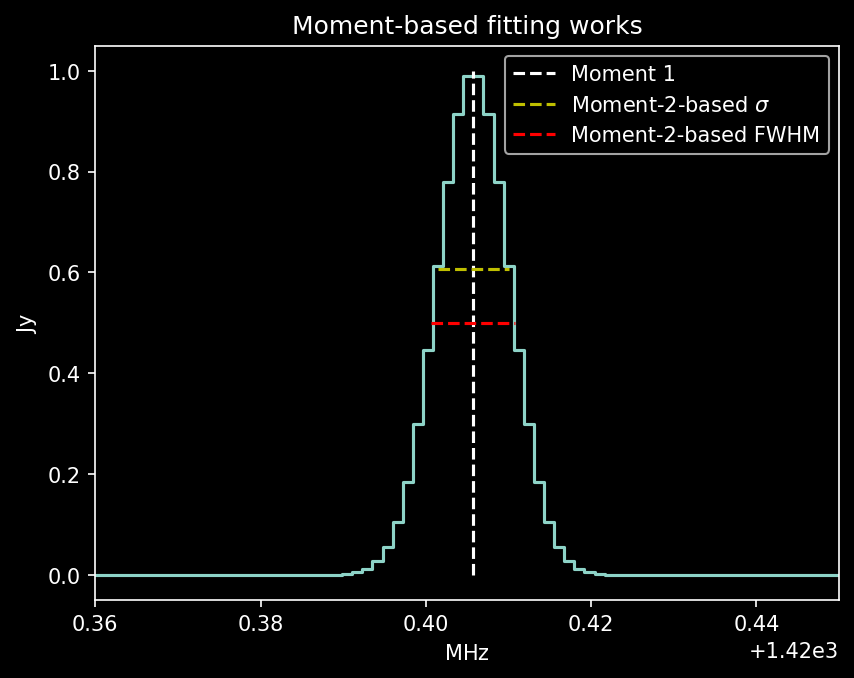

In [65]:
pl.plot(frequency_axis, model_line_profile, drawstyle='steps-mid')
pl.xlim(1420.36,1420.45)
pl.vlines(moment1, 0*u.Jy, 1*u.Jy, color='w', linestyle='--', label='Moment 1')
# the Gaussian width is the half-width at exp(-1/2)
pl.hlines( np.exp(-0.5), moment1-sigma, moment1+sigma, color='y', linestyle='--', label='Moment-2-based $\sigma$')
pl.hlines( 0.5, moment1-sigma*2.35/2, moment1+sigma*2.35/2, color='r', linestyle='--', label='Moment-2-based FWHM');
pl.legend(loc='best');
pl.title("Moment-based fitting works");

# Line Profile Measurements - what about noise?

Even in the presence of noise, moment analysis is very effective - but it can go awry.

In [66]:
# we'll use a specific example to show what happens when noise breaks moment analysis
np.random.seed(0)
uncertainty = 0.1 * model_line_profile.unit
noisy_model_profile = model_line_profile + uncertainty * np.random.randn(model_line_profile.size)

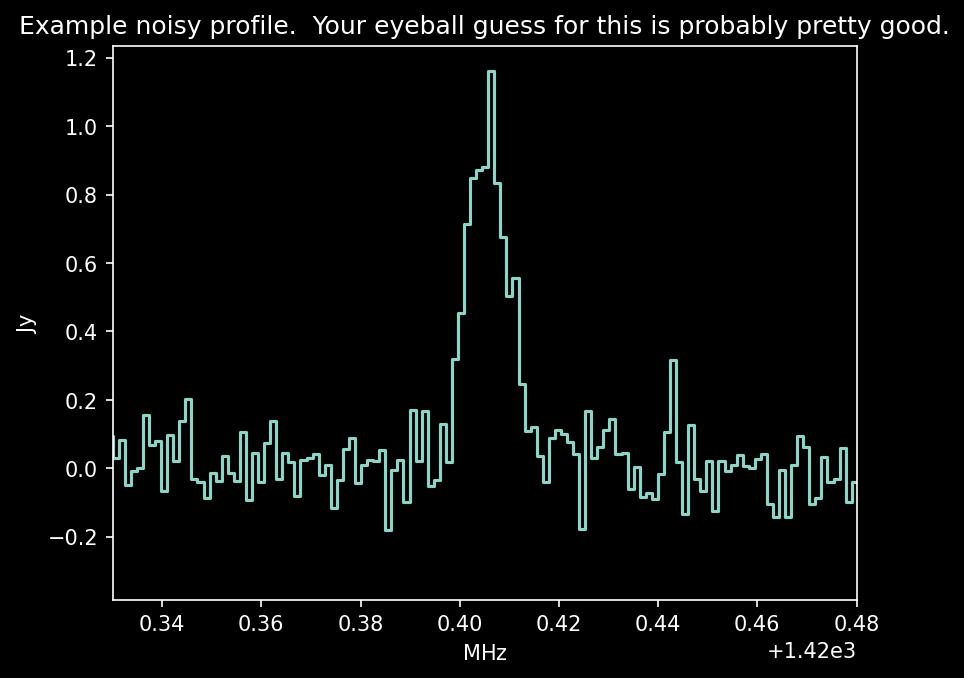

In [67]:
pl.plot(frequency_axis, noisy_model_profile, drawstyle='steps-mid')
pl.xlim(1420.33,1420.48);
pl.title("Example noisy profile.  Your eyeball guess for this is probably pretty good.");

## Moment Analysis on Noisy Data

In [68]:

noisy_moment0 = noisy_model_profile.sum() * delta_nu
noisy_moment1 = (frequency_axis * noisy_model_profile * delta_nu).sum() / noisy_moment0
noisy_moment2 = ( (frequency_axis - noisy_moment1)**2 * noisy_model_profile * delta_nu).sum() / noisy_moment0
noisy_sigma = noisy_moment2**0.5
noisy_moment0, noisy_moment1, noisy_moment2, noisy_sigma

/Users/adam/repos/astropy/astropy/units/quantity.py:674: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Quantity 0.00707108 Jy MHz>,
 <Quantity 1420.86404663 MHz>,
 <Quantity -0.43715543 MHz2>,
 <Quantity nan MHz>)

```
(<Quantity 0.00707108 Jy MHz>,
 <Quantity 1420.86404663 MHz>,
 <Quantity -0.43715543 MHz2>,
 <Quantity nan MHz>)
```    
What happened? 

Let's plot the moment-derived values to see:

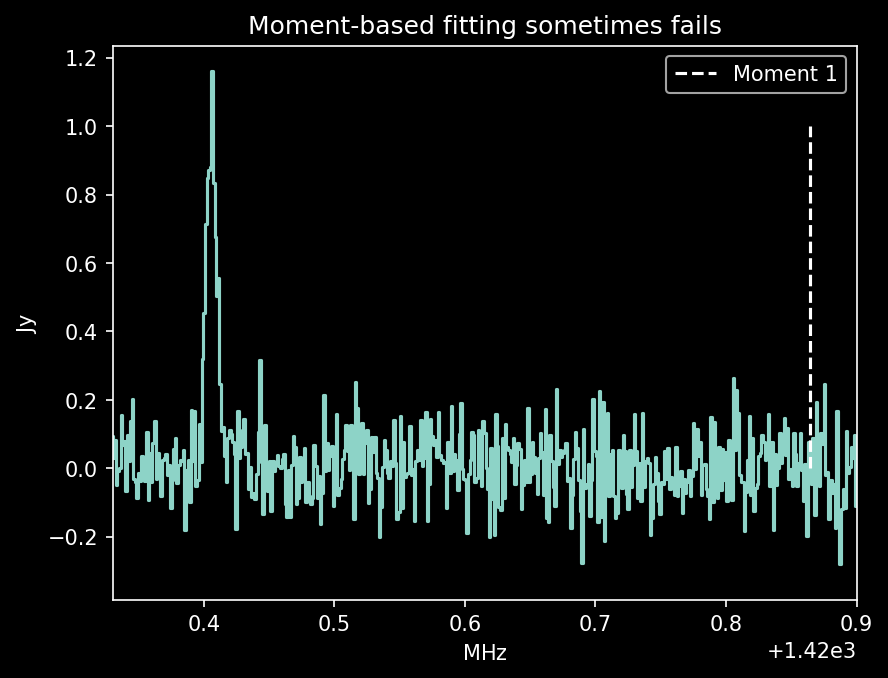

In [69]:
pl.plot(frequency_axis, noisy_model_profile, drawstyle='steps-mid')
pl.xlim(1420.33,1420.9);
pl.vlines(noisy_moment1, 0*u.Jy, 1*u.Jy, color='w', linestyle='--', label='Moment 1')
pl.legend(loc='best');
pl.title("Moment-based fitting sometimes fails");

The centroid is wrong, and the noise won out over the signal.


If we re-measure over a subset - if we "crop" the spectrum to where we know the signal is - we can get a reasonable answer again:

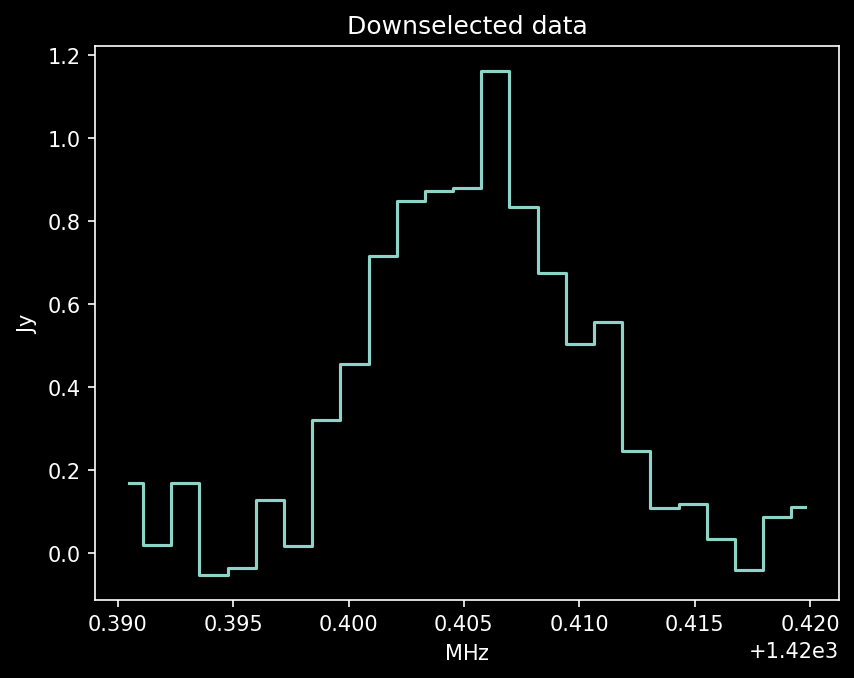

In [70]:
selection = ((frequency_axis > 1420.39 * u.MHz) & (frequency_axis < 1420.42 * u.MHz))
pl.plot(frequency_axis[selection],
        noisy_model_profile[selection], drawstyle='steps-mid');
pl.title("Downselected data");

In [71]:
# moments on the downselected data
noisy_moment0 = noisy_model_profile[selection].sum() * delta_nu
noisy_moment1 = (frequency_axis[selection] * noisy_model_profile[selection] * delta_nu).sum() / noisy_moment0
noisy_moment2 = ( (frequency_axis[selection] - noisy_moment1)**2 * noisy_model_profile[selection] * delta_nu).sum() / noisy_moment0
noisy_sigma = noisy_moment2**0.5
noisy_moment0, noisy_moment1, noisy_moment2, noisy_sigma

(<Quantity 0.01088147 Jy MHz>,
 <Quantity 1420.40551509 MHz>,
 <Quantity 2.4993493e-05 MHz2>,
 <Quantity 0.00499935 MHz>)

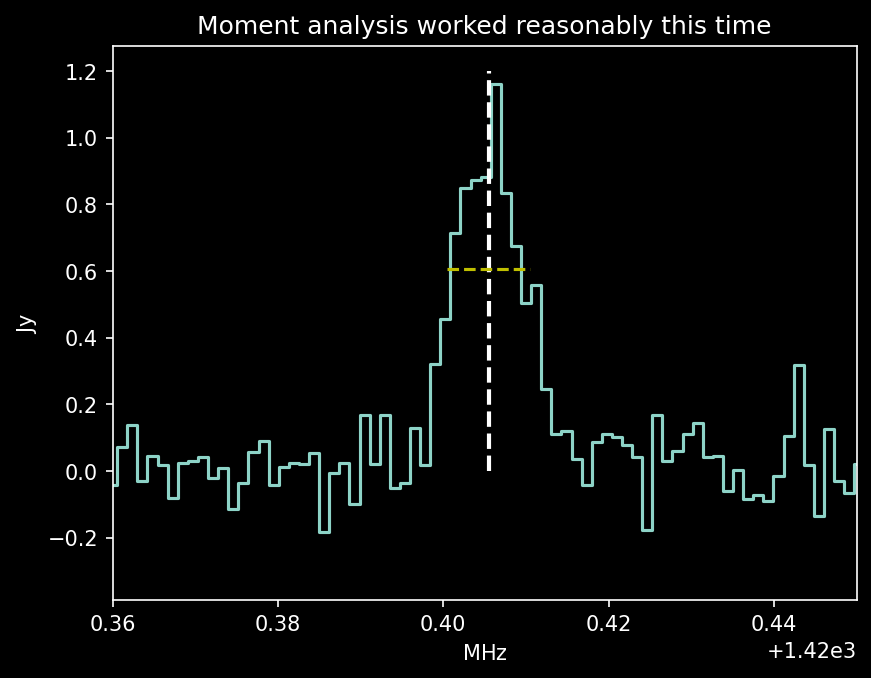

In [72]:
pl.plot(frequency_axis, noisy_model_profile, drawstyle='steps-mid')
pl.xlim(1420.36,1420.45)
pl.vlines(noisy_moment1, 0*u.Jy, 1.2*u.Jy, color='w', linestyle='--', linewidth=2)
pl.hlines(np.exp(-0.5), noisy_moment1-noisy_sigma, noisy_moment1+noisy_sigma, color='y', linestyle='--');
pl.title("Moment analysis worked reasonably this time");

# Moment Analysis - continuum and baselines

Where can moment analysis go really wrong?

If you have a background continuum, none of this works!  We call removing the continuum "baseline subtraction" in the radio.  In the optical, we talk more about continuum modeling.

In [ ]:
noisy_baseline_model_profile = noisy_model_profile + np.poly1d([0.0001,1],r=False)(np.arange(frequency_axis.size))*noisy_model_profile.unit
pl.figure(figsize=(10,4))
pl.suptitle("Example of a baseline problem that's easy to fix", fontsize=16)
pl.subplot(1,2,1).plot(frequency_axis, noisy_baseline_model_profile,
        drawstyle='steps-mid')
pl.title("Full spectrum - a slope is visible")
pl.subplot(1,2,2).plot(frequency_axis, noisy_baseline_model_profile,
        drawstyle='steps-mid')
pl.title("Zoom in on a small spectral area")
pl.xlim(1420.3,1420.51)
pl.ylim(-0.2,2.5);


Why is the baseline a problem?
$$ m_0 = \Sigma  S_\nu \Delta \nu $$
$$ m_1 = \frac{\Sigma \nu S_\nu \Delta \nu}{m_0} $$
$$ m_2 = \frac{\Sigma \nu^2 S_\nu \Delta \nu}{m_0} $$
All of these moments include the flux at each pixel, so if there's a gradient in the flux, it biases the measurement.

In [ ]:
# hackery to make a bad baseline example
# (you don't need to pay close attention to this for now)
np.random.seed(2)
x = np.poly1d([1,2,3] + list(np.random.randn(25)))(np.linspace(-5,5,frequency_axis.size))
x = np.abs(np.fft.fft(x)) / x.sum()
x[0:18] = 0
bad_baseline = np.abs(np.fft.fft(x)) * model_line_profile.unit
noisy_bad_baseline_model_profile = noisy_model_profile + bad_baseline

# Real Bad Baselines

In real life, bad baselines can be really bad, and important (and difficult) to deal with...

<img src="images/41550_2020_1174_Fig9_ESM.webp">

This is an example from the 2020 discovery of phosphine in Venus' atmosphere

In [ ]:
pl.figure(figsize=(10,4))
pl.suptitle("Example of a bad baseline")
pl.subplot(1,2,1).plot(frequency_axis, noisy_bad_baseline_model_profile,
        drawstyle='steps-mid')
pl.title("Full spectrum")
pl.subplot(1,2,2).plot(frequency_axis, noisy_bad_baseline_model_profile,
        drawstyle='steps-mid')
pl.title("Zoomed in")
pl.xlim(1420.3,1420.51)
pl.ylim(-0.2,2.);

## What do we do about bad baselines?

Generally, we try to model and, in the radio,  remove them.  

This can be difficult and can result in fake features in the data, so it helps to know what fake features look like.

We can figure this out by looking at data where we know what the spectrum _should_ look like, either from theory or because we know what other telescopes have observed and we trust that they are reporting the truth.

# Example continuum in optical spectra

We'll examine a spectrum taken from the Pepito spectrograph on CTO.

In [ ]:
from astropy.io import fits
from astropy.wcs import WCS

In [ ]:
# load the data that have already had a wavelength solution applied and 
# saved as a World Coordinate System (WCS)
vega_fh = fits.open('data/Oct5_VegaMean.fits')
vega_spectrum = vega_fh[0].data
ww = WCS(vega_fh[0].header)
wavelengths = ww.pixel_to_world(np.arange(vega_spectrum.size))

In [ ]:
pl.title("Vega spectrum")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.plot(wavelengths, vega_spectrum);

In [ ]:
pl.title(r"Vega spectrum, zoomed in on H$\beta$")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(475, 495)
pl.ylim(3500, 8000)
pl.plot(wavelengths, vega_spectrum);

In [ ]:
pl.title("Vega spectrum, zoomed in\nThese features are not spectral lines - they are instrumental artifacts")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(500, 560)
pl.ylim(7500, 9000)
pl.plot(wavelengths, vega_spectrum);

# Fixing "Baseline" issues

There are many approaches to fixing baseline issues.

Generally, the first thing you want to try is: get better data!  Baseline issues are a _systematic_ uncertainty that can strongly bias your results.  There is a limit on how well you can make a measurement when these are present!

But here we will focus on how to make the best of bad data.

## Baseline Fixing - Radio

In the radio, we often have baseline features that are broad, and bright, compared to our target spectral lines.

In this case, we can use high-order polynomial models to fit the baseline.  We then subtract out the polynomial model.

Sometimes we can zoom far in on the line and fit a _local_, low-order polynomial (e.g., a line).

## Continuum Fitting - optical

We take the same general approach in the optical, but it depends on what we're trying to do.

We'll do the 'zoom-in-on-a-line' method for individual lines.

Generally, radio baselines move around a lot from one observation to the next, but optical instruments are more stable.  We can therefore use a known source as a 'spectral flat field'.

## Spectral Flat Fielding with Vega

Vega's a pretty good spectral flat field.

As an A0 star, it has very few spectral features _except_ for the Hydrogen lines.

We need to remove the hydrogen lines to make it a _really_ good flat, though.  So we'll go through that process:

In [ ]:
pl.title("Vega spectrum, zoomed in on H$\\beta$:\n we now want to fit a linear model to the continuum")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(475, 495)
pl.ylim(3500, 8000)
pl.plot([475.5, 480], [7200, 7200], 'r')
pl.text(477.75, 7300, "Continuum", color='r', ha='center')
pl.plot([490, 494.5], [7500, 7500], 'r')
pl.text(492.25, 7600, "Continuum", color='r', ha='center')
pl.plot(wavelengths, vega_spectrum);

## Zoomed-in continuum fitting process

1. Select the region to fit
2. Use a linear model to fit
3. For optical absorption spectra, divide the data by the model

Because we're dividing the data by the model, we call the result a _normalized_ spectrum: the continuum will be about 1.

In [ ]:
from astropy.modeling.fitting import LinearLSQFitter, LevMarLSQFitter
from astropy.modeling.models import Gaussian1D, Linear1D

In [ ]:
selection = (((wavelengths > 475*u.nm) & (wavelengths < 480*u.nm)) |
             ((wavelengths > 490*u.nm) & (wavelengths < 495*u.nm)))
linfitter = LinearLSQFitter()
continuum_model_fit = linfitter(Linear1D(), wavelengths[selection],
                                vega_spectrum[selection])
continuum_model_fit

In [ ]:
pl.title("Normalized Vega spectrum, zoomed in on H$\\beta$")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(475, 495)
pl.ylim(0.4, 1.1)
pl.plot(wavelengths, vega_spectrum / continuum_model_fit(wavelengths));

# Line Fitting - Gaussian Absorption Line (for Vega flat field)

We want to model out the line, so we're going to fit it and subtract it.

We are modeling the absorption relative to the continuum, so we will now _subtract_ the continuum background off.  This is needed because the Gaussian model is zero at large distances from the center.

1. Subtract continuum from normalized spectrum
2. Select data to fit
3. Provide guesses to fitter
4. Fit
5. Scale the model back to the original data units
6. Subtract from the original data

In [ ]:
absorption_only_profile = vega_spectrum / continuum_model_fit(wavelengths) - 1
selection = ((wavelengths > 480*u.nm) & (wavelengths < 490*u.nm))
guesses = [-0.5, 485, 3] # eyeballed
lmfitter = LevMarLSQFitter()
hbeta_line_fit = lmfitter(Gaussian1D(*guesses), wavelengths[selection],
                          absorption_only_profile[selection])
hbeta_line_fit

In [ ]:
pl.title("Normalized Vega spectrum, zoomed in on H$\\beta$, with fit")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(475, 495)
pl.ylim(0.4, 1.1)
pl.plot(wavelengths, vega_spectrum / continuum_model_fit(wavelengths), label='data');
pl.plot(wavelengths, hbeta_line_fit(wavelengths) + 1, linestyle=':', label='fit')
pl.plot(wavelengths, vega_spectrum / continuum_model_fit(wavelengths) - (hbeta_line_fit(wavelengths) + 1) + 0.5, linestyle='--', label='residual')
pl.legend(loc='best');

In [ ]:
# rescale model to original
model_hbeta_line_profile = hbeta_line_fit(wavelengths[selection]) * continuum_model_fit(wavelengths[selection])
# subtract from original
vega_spectrum_minus_hbeta = vega_spectrum.copy()
vega_spectrum_minus_hbeta[selection] -= model_hbeta_line_profile.value

In [ ]:
pl.title("Vega spectrum - now with H$\\beta$ subtracted")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400,560)
pl.plot(wavelengths, vega_spectrum, linestyle=':');
pl.plot(wavelengths, vega_spectrum_minus_hbeta, linewidth=0.5);

We can quickly repeat the process for H$\gamma$ and H$\delta$

In [ ]:
pl.title(r"Vega spectrum, zoomed in on H$\delta$")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(422, 443)
pl.ylim(1500, 4500)
pl.plot(wavelengths, vega_spectrum);

In [ ]:
vega_spectrum_minus_lines = vega_spectrum_minus_hbeta.copy()

In [ ]:
selection = (((wavelengths > 422*u.nm) & (wavelengths < 426*u.nm)) |
             ((wavelengths > 437.5*u.nm) & (wavelengths < 442.5*u.nm)))
linfitter = LinearLSQFitter()
continuum_model_fit = linfitter(Linear1D(), wavelengths[selection], vega_spectrum[selection])
continuum_model_fit

In [ ]:
absorption_only_profile = vega_spectrum / continuum_model_fit(wavelengths) - 1
selection = ((wavelengths > 426*u.nm) & (wavelengths < 437.5*u.nm))
guesses = [-0.5, 432, 3] # guessed
lmfitter = LevMarLSQFitter()
hdelta_line_fit = lmfitter(Gaussian1D(*guesses), wavelengths[selection], absorption_only_profile[selection])
model_hdelta_line_profile = hdelta_line_fit(wavelengths[selection]) * continuum_model_fit(wavelengths[selection])
vega_spectrum_minus_lines[selection] -= model_hdelta_line_profile.value
hdelta_line_fit

In [ ]:
pl.title(r"Vega spectrum, zoomed in on H$\gamma$")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400, 420)
pl.ylim(500, 2500)
pl.plot(wavelengths, vega_spectrum);

In [ ]:
selection = (((wavelengths > 400*u.nm) & (wavelengths < 404.5*u.nm)) |
             ((wavelengths > 414*u.nm) & (wavelengths < 420*u.nm)))
linfitter = LinearLSQFitter()
continuum_model_fit = linfitter(Linear1D(), wavelengths[selection], vega_spectrum[selection])
continuum_model_fit

In [ ]:
absorption_only_profile = vega_spectrum / continuum_model_fit(wavelengths) - 1
selection = ((wavelengths > 404.5*u.nm) & (wavelengths < 414*u.nm))
guesses = [-0.5, 408, 3] # guessed
lmfitter = LevMarLSQFitter()
hgamma_line_fit = lmfitter(Gaussian1D(*guesses), wavelengths[selection], absorption_only_profile[selection])
model_hgamma_line_profile = hgamma_line_fit(wavelengths[selection]) * continuum_model_fit(wavelengths[selection])
vega_spectrum_minus_lines[selection] -= model_hgamma_line_profile.value
hgamma_line_fit

In [ ]:
pl.title("Vega spectrum - now with H$\\beta$, H$\\gamma$, and H$\\delta$ subtracted")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400,560)
pl.plot(wavelengths, vega_spectrum, linestyle=':');
pl.plot(wavelengths, vega_spectrum_minus_lines, linewidth=0.5);

# Spectral flatfielding

We can now use this as a spectral flatfield model for our other spectra.  So, for example, let's compare to Jupiter:

In [ ]:
# load the data that have already had a wavelength solution applied and saved as a World Coordinate System (WCS)
jupiter_fh = fits.open('data/Oct5_JupiterMean.fits')
jupiter_spectrum = jupiter_fh[0].data
ww = WCS(jupiter_fh[0].header)
wavelengths = ww.pixel_to_world(np.arange(jupiter_spectrum.size))

In [ ]:
pl.title("Jupiter spectrum")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400,560)
pl.plot(wavelengths, jupiter_spectrum);

In [ ]:
pl.title("Jupiter spectrum divided by line-subtracted Vega spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400, 560)
pl.ylim(0, 0.7)
pl.plot(wavelengths, jupiter_spectrum / vega_spectrum_minus_lines);

In [ ]:
pl.title("Jupiter spectrum divided by line-subtracted Vega spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400, 560)
pl.ylim(0, 0.7)
pl.plot(wavelengths, jupiter_spectrum / 9000, label='Before');
pl.plot(wavelengths, jupiter_spectrum / vega_spectrum_minus_lines, label='After');
pl.legend(loc='best');

In [ ]:
pl.title("Normalized Jupiter spectrum divided by line-subtracted Vega spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(430, 560)
pl.ylim(0.8, 1.2)
selection = wavelengths>430*u.nm
jupiter_linmod = linfitter(Linear1D(), wavelengths[selection], jupiter_spectrum[selection])
jupiter_div_vega_linmod = linfitter(Linear1D(), wavelengths[selection], (jupiter_spectrum / vega_spectrum_minus_lines)[selection])
pl.plot(wavelengths, jupiter_spectrum / jupiter_linmod(wavelengths), label='Before', linewidth=1);
pl.plot(wavelengths, jupiter_spectrum / vega_spectrum_minus_lines / jupiter_div_vega_linmod(wavelengths), label='After');
pl.legend(loc='best');

# Spectrally Flat-Fielded

The flat-fielded spectrum gives a better representation of the true spectrum, since it's now no longer mixing in instrumental artifacts.

# Brief Calibration wrap-up

These normalized spectra are _not_ flux-calibrated.

Generally, obtaining flux-calibrated optical spectra is challenging and achievable only by very careful instrument construction and operation and/or space-based operation.  

We call flux-calibrated spectra "spectrophotometric" observations, since we can measure _both_ the spectroscopic properties (wavelength, line width, and fractional absorption) and the photometric properties (number of photons).

# What use are un-flux-calibrated spectra?

Our measurements are still useful!

We can measure the flux of the line _relative to_ the continuum.

As long as we have some other way to measure the total continuum flux - say, with imaging photometry - we can re-calibrate the spectra to match.

However, we often only care about the line strength relative to the continuum; in many circumstances, most or all of the physical information is contained in this relative measurement.

# Equivalent Width

The *Equivalent Width* of a line is a way to summarize the measurement relative to the continuum.

It is the width of an absorption line that bottoms out at zero with the same area as the observed line.

In other words, it is the integral of the absorption line divided by the continuum.

In [ ]:
pl.title("EQW Example: the line profiles have the same area")
pl.ylabel("Normalized Continuum plus Line model")
pl.xlabel("Wavelength [nm]")
pl.xlim(475, 495)
pl.ylim(-0.1, 1.1)
eqw_hbeta = - hbeta_line_fit.amplitude * (2*np.pi)**0.5 * hbeta_line_fit.stddev
#pl.plot(wavelengths, vega_spectrum / continuum_model_fit(wavelengths), label='data');
pl.plot(wavelengths, hbeta_line_fit(wavelengths) + 1, linestyle=':', label='Fitted H$\\beta$ model')
pl.plot(u.Quantity([450*u.nm, hbeta_line_fit.mean - eqw_hbeta/2, hbeta_line_fit.mean - eqw_hbeta/2,
         hbeta_line_fit.mean + eqw_hbeta/2, hbeta_line_fit.mean + eqw_hbeta/2, 500*u.nm]),
        [1, 1, 0, 0, 1, 1],
        color='w', linewidth=0.5, label='EQW square spectrum')
pl.legend(loc='best');